# Requirements

In [32]:
#!pip install pingouin

import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import seaborn as sns
import pandas as pd
from pathlib import Path
from typing import TypeVar, List

# CSV

### Se ha filtrado con un criterio de esperanza de vida la edad para evitar la mayor cantidad de outliers

In [33]:

PathLike = TypeVar("PathLike", str, Path, None)

def std_transform(
    dfPath: PathLike = None,
    bornColname: str = 'birth',
    dateBornSchema: str = None,
    inscriptionDateSchema: str = None,
    minAge: int = 17,
    maxAge: int = 82,
    strCols: List[str]=['last_name','email','university','career','location'],
    pathPostalCode: PathLike = None,
    yyBornDate: bool = False,
    pCode: str = 'codigo_postal',
    lCode: str = 'localidad',
    ):
    df = pd.read_csv(dfPath,encoding="utf-8")
    df['inscription_date'] = pd.to_datetime(df['inscription_date'],format=inscriptionDateSchema)
    if yyBornDate:
        df[bornColname] = df[bornColname].map(lambda x: '19'+ x if int(x[0:2])>5  else '20'+ x)
    try:
        df[bornColname] = pd.to_datetime(df[bornColname],format=dateBornSchema)
    except:
        pass
    df['age'] = np.int64(np.floor((df['inscription_date']-df[bornColname]) / np.timedelta64(1, 'Y')))
    df = df.drop([bornColname], axis=1)
    if 'Unnamed: 0' in df.columns:
        df = df.drop(['Unnamed: 0'], axis=1)
    df = df[df['age'] >= minAge]
    df = df[df['age'] <= maxAge]
    for i in strCols:
        if i in df.columns:
            df[i] = df[i].apply(lambda x : ' '.join(x.lower().replace('-', ' ').split()))
    cp = pd.read_csv(pathPostalCode)
    cp[lCode] = cp[lCode].apply(lambda x : ' '.join(x.lower().replace('-', '').split()))
    if 'location' not in df.columns and 'postal_code' in df.columns:
        df = pd.merge(left=df,right=cp, left_on='postal_code', right_on=pCode).rename(columns={'localidad':'location'})
        df['location'] = df['location'].apply(lambda x : ' '.join(x.lower().replace('-', '').split()))
        df = df.drop([pCode], axis=1)
    if 'location' in df.columns and 'postal_code' not in df.columns:
        
        df = pd.merge(left=df,right=cp, left_on='location', right_on=lCode).rename(columns={'codigo_postal':'postal_code'})
        df = df.drop([lCode], axis=1)
    df['gender'] = df['gender'].map(lambda x : 'female' if x == 'F' else 'male').astype("category") 
    return df
moron_csv = r'../include/GFUMoron.csv'
pc_path = r'../assets/codigos_postales.csv'


std_kwargs = {
                'dfPath':moron_csv,
                'dateBornSchema': "%d/%m/%Y",
                'inscriptionDateSchema': "%d/%m/%Y",
                'minAge': 17,
                'maxAge': 82,
                'pathPostalCode': pc_path,
            }

dfm = std_transform(**std_kwargs)


rio_cuarto_csv = r'../include/GFUNRioCuarto.csv'
rio_cuarto_txt = r'../include/GFUNRioCuarto.txt'
pc_path = r'../assets/codigos_postales.csv'


std_kwargs = {
                'dfPath':rio_cuarto_csv,
                'dateBornSchema': "%Y/%b/%d",
                'inscriptionDateSchema': "%y/%b/%d",
                'minAge': 17,
                'maxAge': 82,
                'pathPostalCode': pc_path,
                'yyBornDate':True
                }

dfr = std_transform(**std_kwargs)





# obtención de provincia

obtencion de provincias mediante scraping a https://codigo-postal.co

esta función fue empleada para obtener los códigos postales y generar el documento cp_province.csv

In [34]:

#!pip install beautifulsoup4
from bs4 import BeautifulSoup
import urllib.request
def province(pc):
    html = urllib.request.urlopen(rf'https://codigo-postal.co/argentina/cp/{pc}/').read().decode()
    soup = BeautifulSoup(html)
    tags = soup('td')
    for tag in tags:
        if tag:
            return str(tag)[4:-5]
        return 'NotFound'
        


In [35]:
import pandas as pd
cp = pd.read_csv(r'./csv/cp_province.csv')
def merge_province(df):
    df = pd.merge(left=df,right=cp[['province','codigo_postal']], left_on='postal_code', right_on='codigo_postal')
    df = df[df['province'] != 'Not Found']
    return df


dfm = merge_province(dfm)
dfr = merge_province(dfr)

# Codificacion de carreras

- Ciencias físico-matemáticas y de las ingenierías (FM)
- Ciencias biológicas, químicas y de la salud (BS)
- Ciencias sociales (CS)
- Ciencias economicas, administracion t gestión (CE)
- Humanidades y de las artes (AR)

In [36]:
#df['career'].unique()
careers ={
    'diseño de imagen y sonido':'AR',
    'farmacia':'BS',
    'medicina':'BS',
    'ingeniería en informática':'FM', 
    'ingeniería electrónica':'FM',
    'licenciatura en administración':'CE',
    'licenciatura en terapia ocupacional':'CS', 
    'arquitectura':'AR',
    'ciencias veterinarias':'BS', 
    'licenciatura en relaciones del trabajo':'CS',
    'licenciatura en ciencia política':'CS',
    'licenciatura en ciencias geológicas':'FM',
    'licenciatura en producción de bioimagenes':'BS', 
    'bioquímica':'BS',
    'ingeniería mecánica':'FM', 
    'actuario':'CE',
    'licenciatura en planificación y diseño del paisaje':'AR',
    'licenciatura en musicoterapia':'BS',
    'licenciatura en ciencias de la computación':'FM',
    'licenciatura en artes':'AR',
    'licenciatura en gestión de agroalimentos':'BS',
    'licenciatura en ciencias antropológicas':'CS',
    'licenciatura en ciencias de la educación':'CS',
    'licenciatura en sociología':'CS',
    'licenciatura en ciencias biológicas':'BS',
    'licenciatura en ciencia y tecnología de alimentos':'BS',
    'diseño industrial':'FM', 
    'contador público':'CE', 
    'agronomía':'FM',
    'licenciatura en psicología':'CS',
    'licenciatura en ciencias ambientales':'FM', 
    'técnico para bioterios':'BS',
    'licenciatura en kinesiología y fisiatría':'BS',
    'licenciatura en artes':'AR', 
    'licenciatura en administración':'CE',
    'licenciatura en ciencia y tecnología de alimentos':'BS',
    'ingeniería en informática':'FM', 
    'ciencias veterinarias':'BS', 
    'actuario':'CE',
    'licenciatura en kinesiología y fisiatría':'BS', 
    'arquitectura':'AR',
    'bioquímica':'BS', 
    'licenciatura en musicoterapia':'BS', 
    'medicina':'BS',
    'licenciatura en gestión de agroalimentos':'CE',
    'licenciatura en ciencias ambientales':'FM', 
    'técnico para bioterios':'BS',
    'licenciatura en planificación y diseño del paisaje':'AR',
    'ingeniería mecánica':'FM', 
    'licenciatura en terapia ocupacional':'CS',
    'licenciatura en ciencias geológicas':'FM',
    'licenciatura en sociología':'CS',
    'licenciatura en producción de bioimagenes':'BS',
    'licenciatura en relaciones del trabajo':'CE', 
    'contador público':'CE',
    'licenciatura en ciencias de la computación':'FM',
    'licenciatura en ciencias de la educación':'CS', 
    'farmacia':'BS',
    'ingeniería electrónica':'FM', 
    'agronomía':'FM',
    'licenciatura en psicología':'BS',
    'licenciatura en ciencias antropológicas':'CS', 
    'diseño industrial':'AR',
    'licenciatura en ciencia política':'CS',
    'licenciatura en ciencias biológicas':'BS', 
    'diseño de imagen y sonido':'AR'
}   

def career_category(data):
    for k , v in careers.items():
        if k == data:
            return v
    else:
        return 'Not Found'

dfm['carrer_category']= dfm['career'].map(career_category)
dfr['carrer_category']= dfr['career'].map(career_category)



# Agrupación de provincias por zona regional.
 
 <img src='.\images\zonasarg.png'>

Adicionalmente se generará una columna donde se identificara si el estudiante proviene de la misma provincia o se otra, categorizándolos como [local-visitor]


In [37]:

region = {
    'Santa Fé':'RC',
    'La Rioja':'CY', 
    'Jujuy':'NOA', 
    'Mendoza':'CY', 
    'Tucumán':'NOA',
    'Buenos Aires':'RC', 
    'Chaco':'NEA', 
    'Catamarca':'NOA', 
    'Entre Ríos':'RC',
    'La Pampa':'RP', 
    'Chubut':'RP', 
    'Salta':'NOA', 
    'San Luis':'CY', 
    'Río Negro':'RP',
    'Corrientes':'NEA', 
    'Misiones':'NEA', 
    'San Juan':'CY', 
    'Santa Cruz':'RP', 
    'Formosa':'NEA',
    'Tierra del Fuego':'RP', 
    'Santiago del Estero':'NOA', 
    'Neuquén':'RP', 
    'Córdoba':'RC'
}
def career_category(data):
    for k , v in region.items():
        if k == data:
            return v
    else:
        return 'Not Found'

dfm['region']= dfm['province'].map(career_category)
dfr['region']= dfr['province'].map(career_category)

### concatenación de dataframes

In [38]:
dft = pd.concat([dfm,dfr])



# Datos descriptivos

In [39]:
dfr['age'].describe()

count    1028.000000
mean       49.500973
std        19.452962
min        17.000000
25%        32.750000
50%        48.000000
75%        67.000000
max        82.000000
Name: age, dtype: float64

In [40]:
dfm['age'].describe()

count    940.000000
mean      50.457447
std       19.142960
min       17.000000
25%       34.000000
50%       51.000000
75%       67.000000
max       82.000000
Name: age, dtype: float64

<AxesSubplot:title={'center':'Edades por Universidad '}, xlabel='age', ylabel='university'>

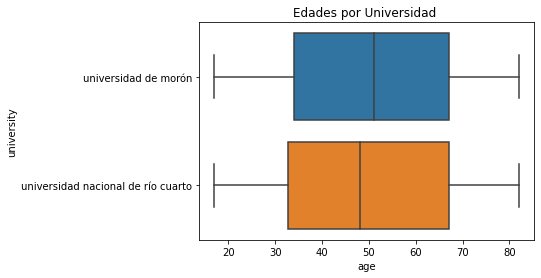

In [41]:
plt.title('Edades por Universidad ')
sns.boxplot(data=dft, x="age", y="university")

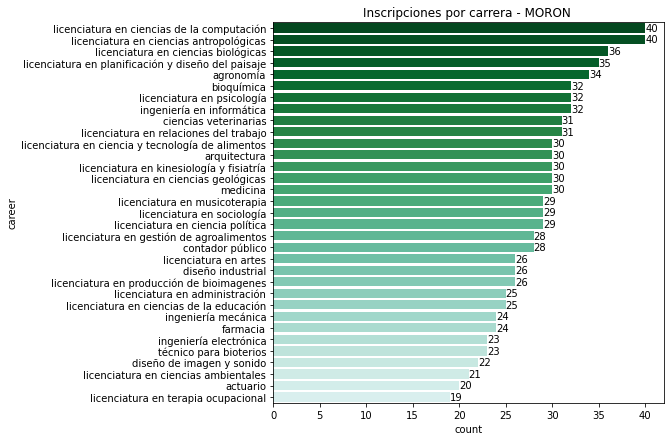

In [42]:

def graph_count(df,name):
    plt.figure(figsize=(7,7))
    plt.title(F'Inscripciones por carrera - {name} ')
    dfg_carrera = df[['career', 'university']].groupby('career').count().sort_values('university', ascending=False)
    ax = sns.countplot(data=df, y='career', orient='h', order=dfg_carrera.index,saturation=0.9, palette= sns.color_palette("BuGn_r", 40))
    ax.bar_label(ax.containers[0], label_type='edge')
    plt.show()
graph_count(dfm,'MORON')

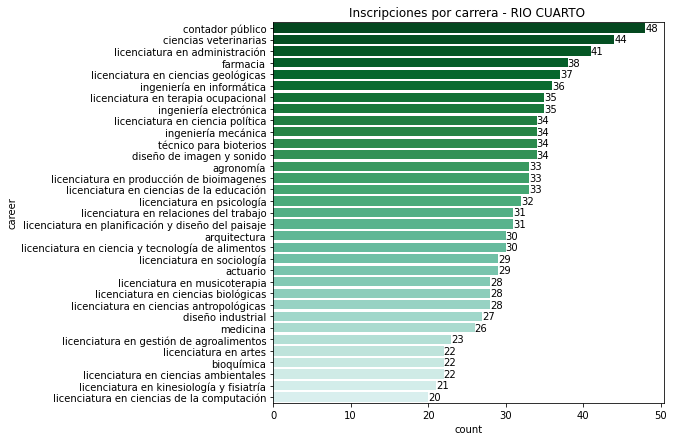

In [43]:
graph_count(dfr,'RIO CUARTO')

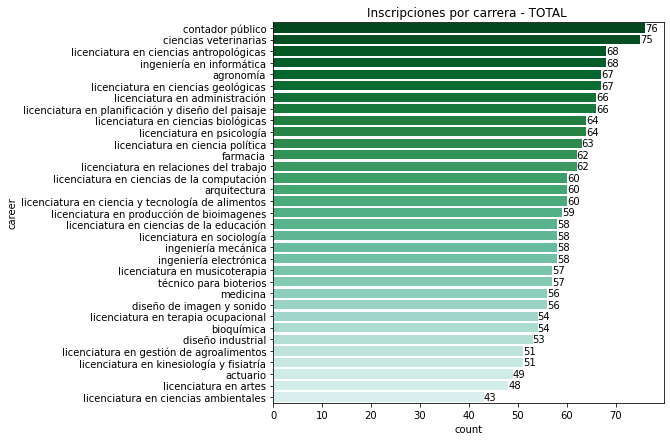

In [44]:
graph_count(dft,'TOTAL')

# Codificacion de prueba de independencia


El estadístico chi-2 es empleado en este caso para realizar una prueba de hipótesis de independencia, mientras que el estadístico v-Cramer medirá el grado de asociación entre las variables, este varía entre 0 y 1, siendo más fuerte la dependencia entre variables mientras más cercano a 1 esté
$$ \chi^{2}_{\left(f-1\right)\left(c-1\right)gl}=\sum_i\frac{\left(fo_{i}-fe_{i}\right)^{2}}{fe_{i}} $$
$$ v-Cramer = \sqrt{\frac{\chi^{2}_{\left(f-1\right)\left(c-1\right)gl}}{N* min\left\{f-1,c-1\right\}}}$$

In [45]:


def vCramer(dfx,dfy):

    data_crosstab = pd.crosstab(dfx, dfy,  margins = False) 
    x = np.array(data_crosstab)
    stat, p = stats.chi2_contingency(x, correction=False)[0:2]
    #print(f'chi-2 observado: {stat}')

    N = np.sum(x)
    minimum_dimension = min(x.shape)-1
    gl = (x.shape[0]-1) * (x.shape[1]-1)
    #print(f'grados de libertad : {gl}')
    #print(f'p-value {p}')
 
    # Calculate Cramer's V
    result = np.sqrt((stat/N) / minimum_dimension)
    
    #print(f'v-Cramer observado: {result}')
    
    return [p,result]
# para universidad de Moron (Buenos Aires)
dfm['local'] = dfm['province'].map(lambda x: 'local' if x == 'Buenos Aires' else 'visitor')
# para universidad de Rio cuarto (Cordoba)
dfr['local'] = dfr['province'].map(lambda x: 'local' if x == 'Córdoba' else 'visitor')

### Calculo de niveles de asociación 
- género y distintos agregados de locación (provincia, región)
- género y agregados de carrera (carrera y carrera agregada en grandes grupos)
- carera agregada en grandes grupos y agregados por locación


In [46]:
def test_vCramer(df):
       datos = [vCramer(df['gender'],df['province']),
              vCramer(df['gender'],df['region']),
              vCramer(df['gender'],df['career']),
              vCramer(df['gender'],df['carrer_category']),
              vCramer(df['carrer_category'],df['province']),
              vCramer(df['carrer_category'],df['region']),
              ]

       idx = ['genero-provincia', 'genero-region','genero-carrera',
              'genero-categoria de carrera','categoria de carrera-province','categoria de carrera-region',] 
       col = ['p-value', 'v-Cramer'] 
       test_vC = pd.DataFrame(datos, columns=col, index=idx)
       return test_vC



#### Universidad de Moron
#### Se puede observar ausencia de rechazo de hipótesis de independencia, aunque el mas proximo a este genero-carrera.

In [47]:
test_vCramer(dfm)

,p-value,v-Cramer
genero-provincia,0.702065,0.138633
genero-region,0.349508,0.068741
genero-carrera,0.217447,0.200846
genero-categoria de carrera,0.686060,0.049152
categoria de carrera-province,0.616606,0.149000
categoria de carrera-region,0.257675,0.071487


#### Universidad Rio Cuarto
#### Se puede observar solo un rechazo de hipótesis de independencia para un error tipo 1 del 0.05 entre género y carrera. Del resto de relaciones es esperable un gráfico homogéneo en términos de frecuencias y por lo tanto solo se realizarán algunos para exponer tal punto.

In [48]:
test_vCramer(dfr)

,p-value,v-Cramer
genero-provincia,0.661881,0.134984
genero-region,0.443149,0.060271
genero-carrera,0.010850,0.227363
genero-categoria de carrera,0.414140,0.061911
categoria de carrera-province,0.446628,0.147217
categoria de carrera-region,0.836307,0.050655


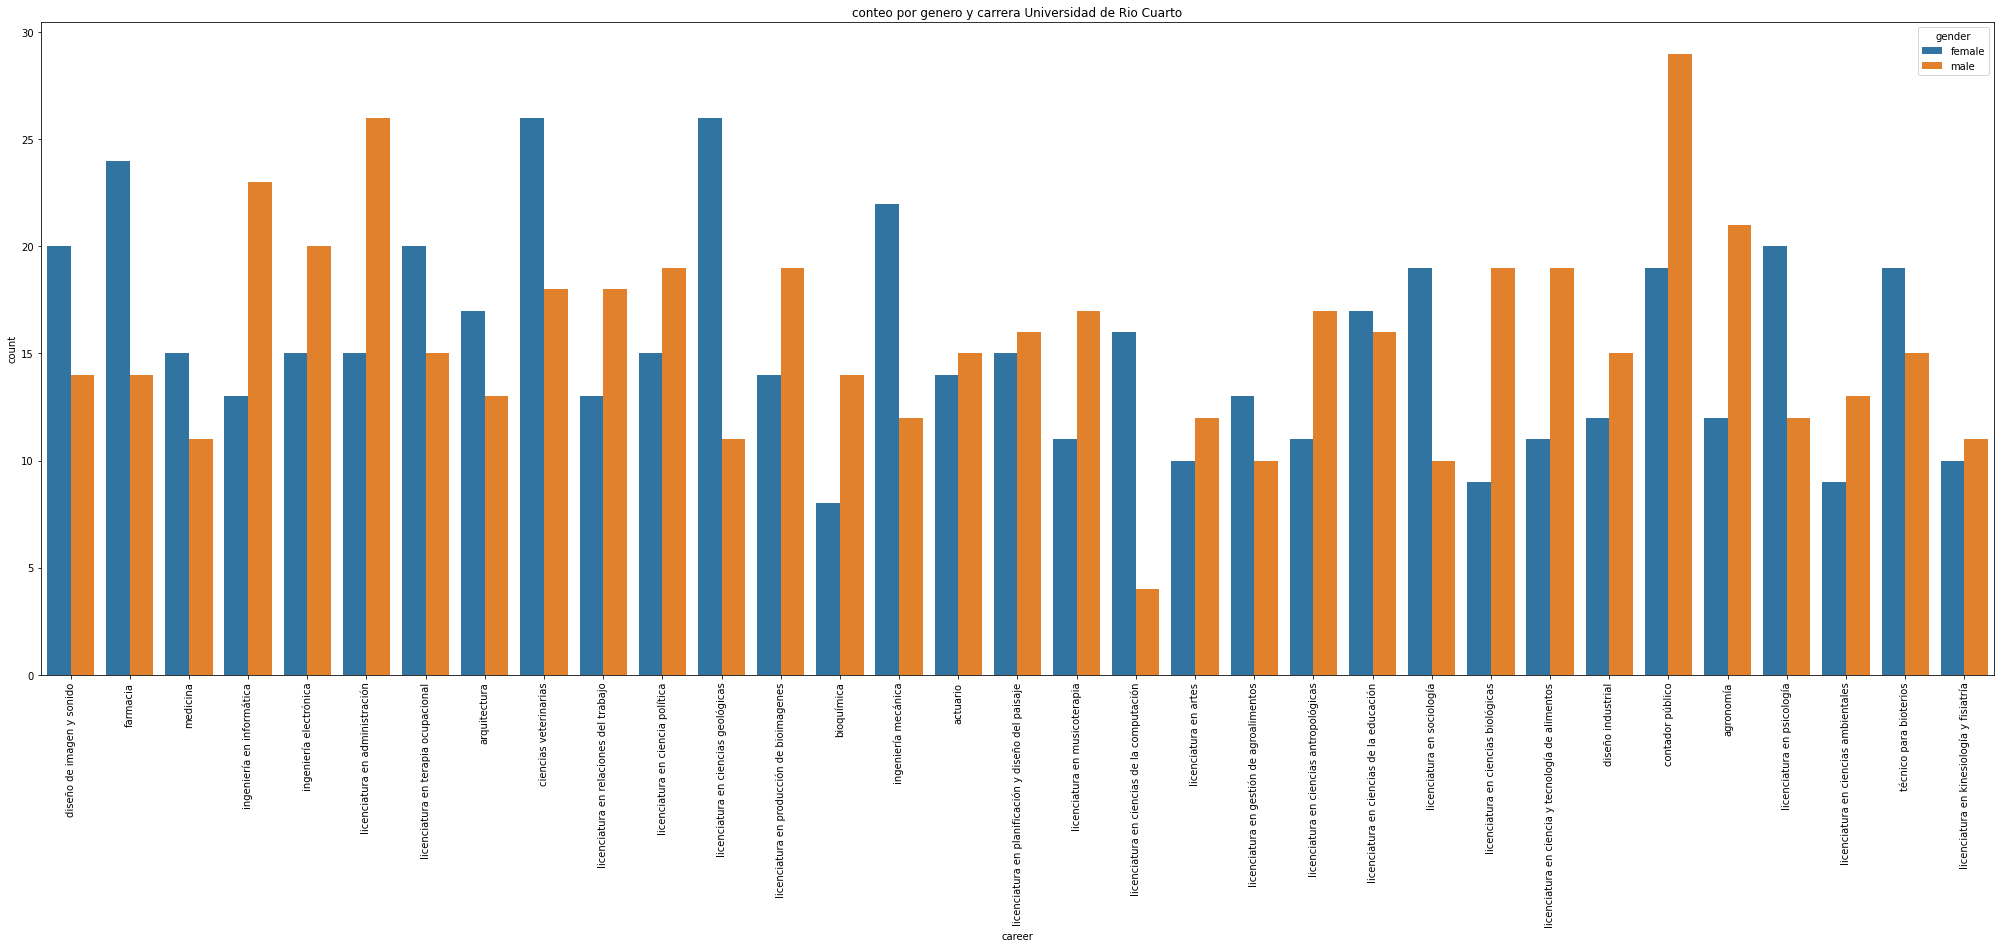

In [49]:

fig, ax = plt.subplots(1, 1, figsize=(35, 12))
plt.title('conteo por genero y carrera Universidad de Rio Cuarto')
sns.countplot(x='career',hue='gender', data=dfr).set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.show()

In [50]:
test_vCramer(dft)

,p-value,v-Cramer
genero-provincia,0.792383,0.091456
genero-region,0.268170,0.051363
genero-carrera,0.491802,0.126512
genero-categoria de carrera,0.533957,0.039972
categoria de carrera-province,0.595809,0.103404
categoria de carrera-region,0.843483,0.036392


### Conclusión 

#### Se puede observar solo un rechazo de hipótesis de independencia para un error tipo 1 del 0.05 entre género y carrera para la universidad de Rio Cuarto.Tal relación desaparece al tomar la totalidad de los datos. Del resto de relaciones es esperable un gráfico homogéneo en términos de frecuencias y por lo tanto solo se realizarán algunos para exponer tal punto.


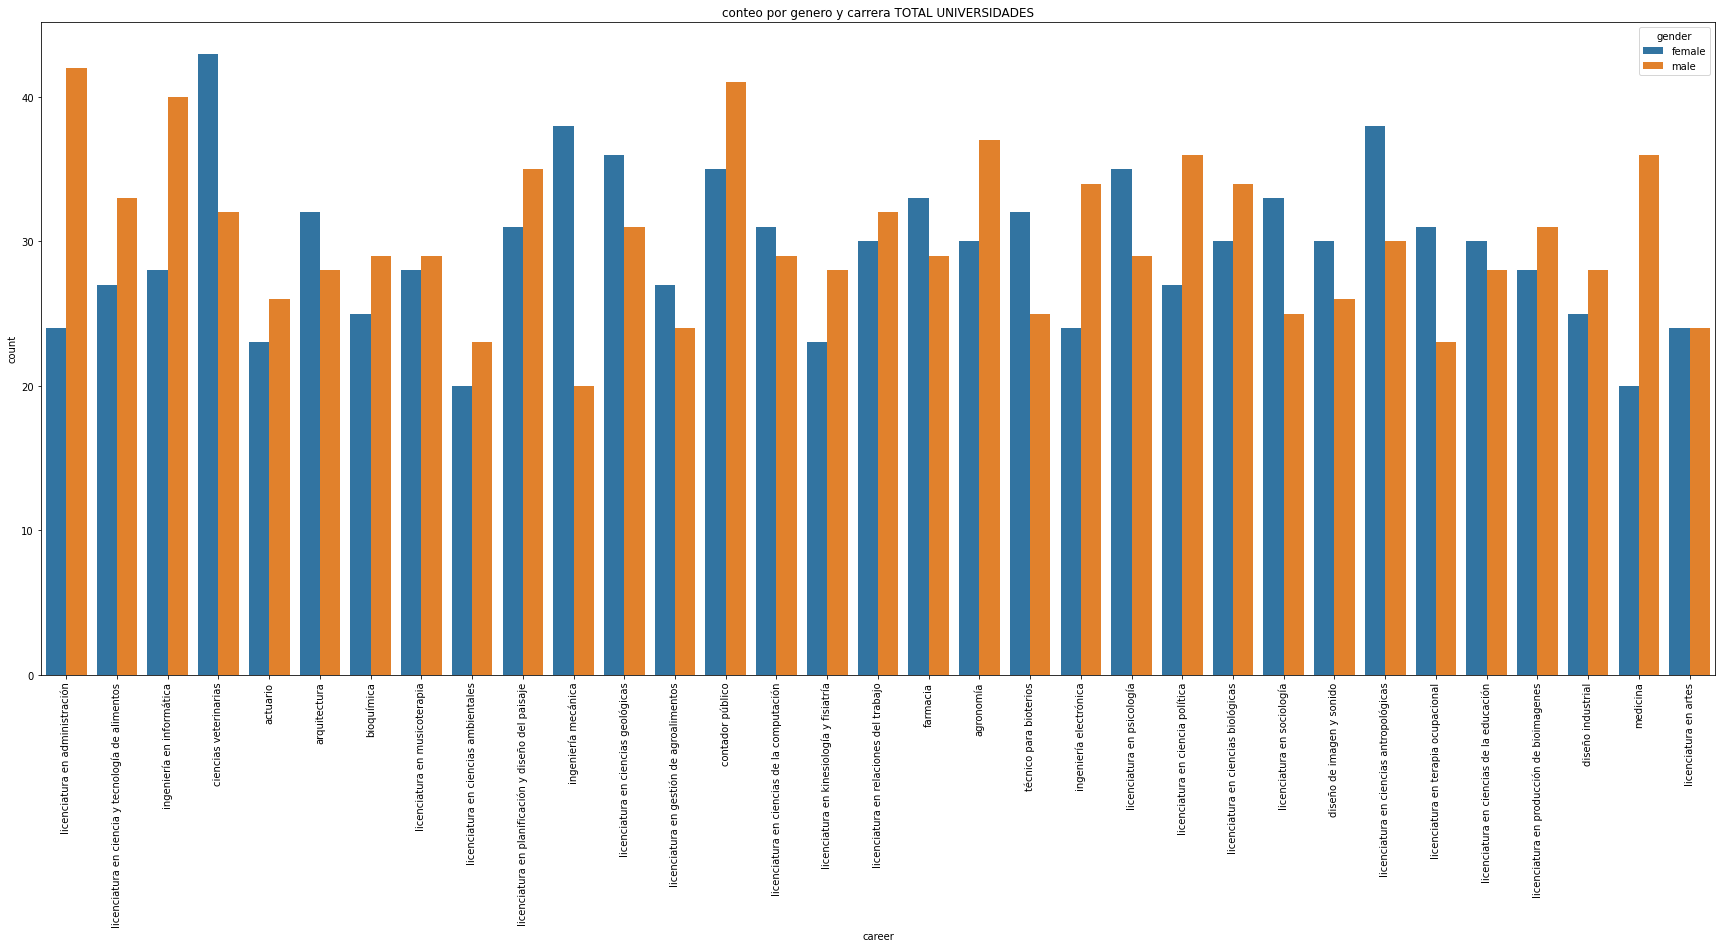

In [51]:

fig, ax = plt.subplots(1, 1, figsize=(30, 12))
plt.title('conteo por genero y carrera TOTAL UNIVERSIDADES')
sns.countplot(x='career',hue='gender', data=dft).set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.show()

En las carreras de fuerte prevalencia femenina se puede mencionar veterinaria, arquitectura, mecanica, o antropología. mientras que en las de prevalencia masculina destacan contador publico, administracion, medicina, computación o farmacia.

es llamativo que tal diferencia estadística no se mantenga al segmentar las carreras, lo cual indica que la población se distribuye homogéneamente entre facultades y parece ser no verosímil empíricamente 

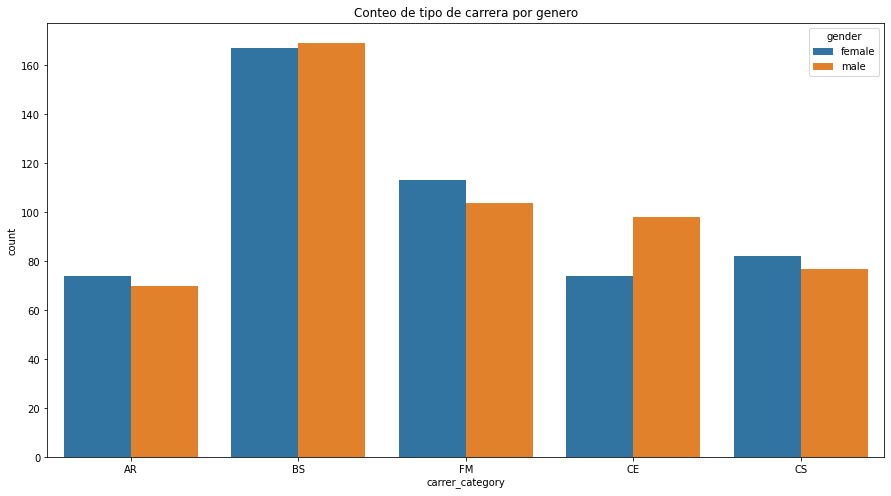

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
plt.title('Conteo de tipo de carrera por genero')
sns.countplot(x='carrer_category',hue='gender', data=dfr)
plt.show()

En estos últimos, aunque no significativamente, se puede observar que la población masculina tiene mayor presencia de inscripción en carreras de ciencias económicas mientras que la población femenina en fisica y matemáticas.

# Test para comparación de medias ANOVA
Empleado para contrastar la hipótesis de igualdad de medias por grupos

de cumplirse normalidad y homocedasticidad entonces el cociente de suma de cuadrados tiene distribución F

$$ \frac{CME}{CMD}\sim F_{\frac{GL-CME}{GL-CMD}} $$

debido a que es común el no cumplir con los axiomas para que la distribución sea F, se optara como alternativa la prueba no paramétrica kruskal wallis en caso de no cumplirse

In [66]:
import pingouin as pg

def str_aov_kruskal(df,numeric,category):
    normality = True
    try:
        normality_test = pg.normality(data=df, dv=numeric, group=category)
        for i in normality_test['normal']:
            if i == False:
                normality = False
                break
    except:
        print('Cant check normality')
        normality = False
    
    if normality:
        if pg.homoscedasticity(data=df, dv=numeric, group=category, method='levene')['equal_var'][0]:  
            print('homocedasticidad')
            return pg.anova(data=df, dv=numeric, between=category, detailed=True)
    if pg.homoscedasticity(data=df, dv=numeric, group=category, method='levene')['equal_var'][0]:  
        print('homocedasticidad')
    return pg.kruskal(data=df, dv=numeric, between=category)


## Calculo de diferencias de medias (para edad)

#### Rio Cuarto 
#### Se observan diferencias significativas en edad respecto a (genero, carrera)

In [67]:

print(str_aov_kruskal(dfr,'age','carrer_category'))
print(str_aov_kruskal(dfr,'age','gender'))
print(str_aov_kruskal(dfr,'age','career'))
print(str_aov_kruskal(dfr,'age','region'))
print(str_aov_kruskal(dfr,'age','province'))


                  Source  ddof1         H     p-unc
Kruskal  carrer_category      4  2.311266  0.678719
homocedasticidad
         Source  ddof1         H     p-unc
Kruskal  gender      1  7.128631  0.007586
homocedasticidad
         Source  ddof1          H     p-unc
Kruskal  career     32  66.229539  0.000353
homocedasticidad
         Source  ddof1         H     p-unc
Kruskal  region      4  3.042743  0.550698
Cant check normality
homocedasticidad
           Source  ddof1          H     p-unc
Kruskal  province     22  23.013512  0.400967


<AxesSubplot:title={'center':'Rio Cuarto '}, xlabel='gender', ylabel='age'>

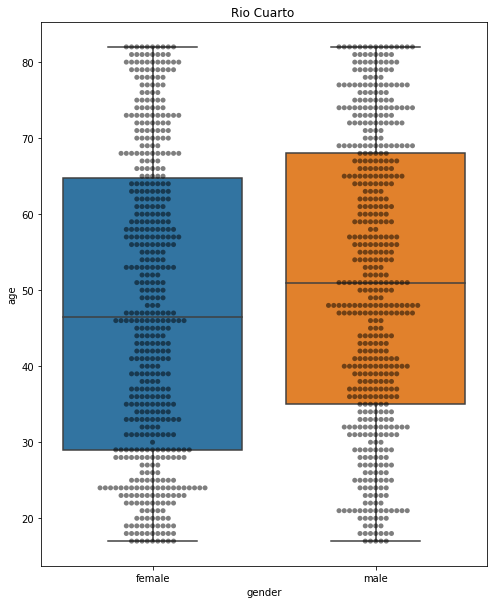

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(8, 10))
plt.title('Rio Cuarto ')
sns.boxplot(x="gender", y="age", data=dfr, ax=ax)
sns.swarmplot(x="gender", y="age", data=dfr, color='black', alpha = 0.5, ax=ax)

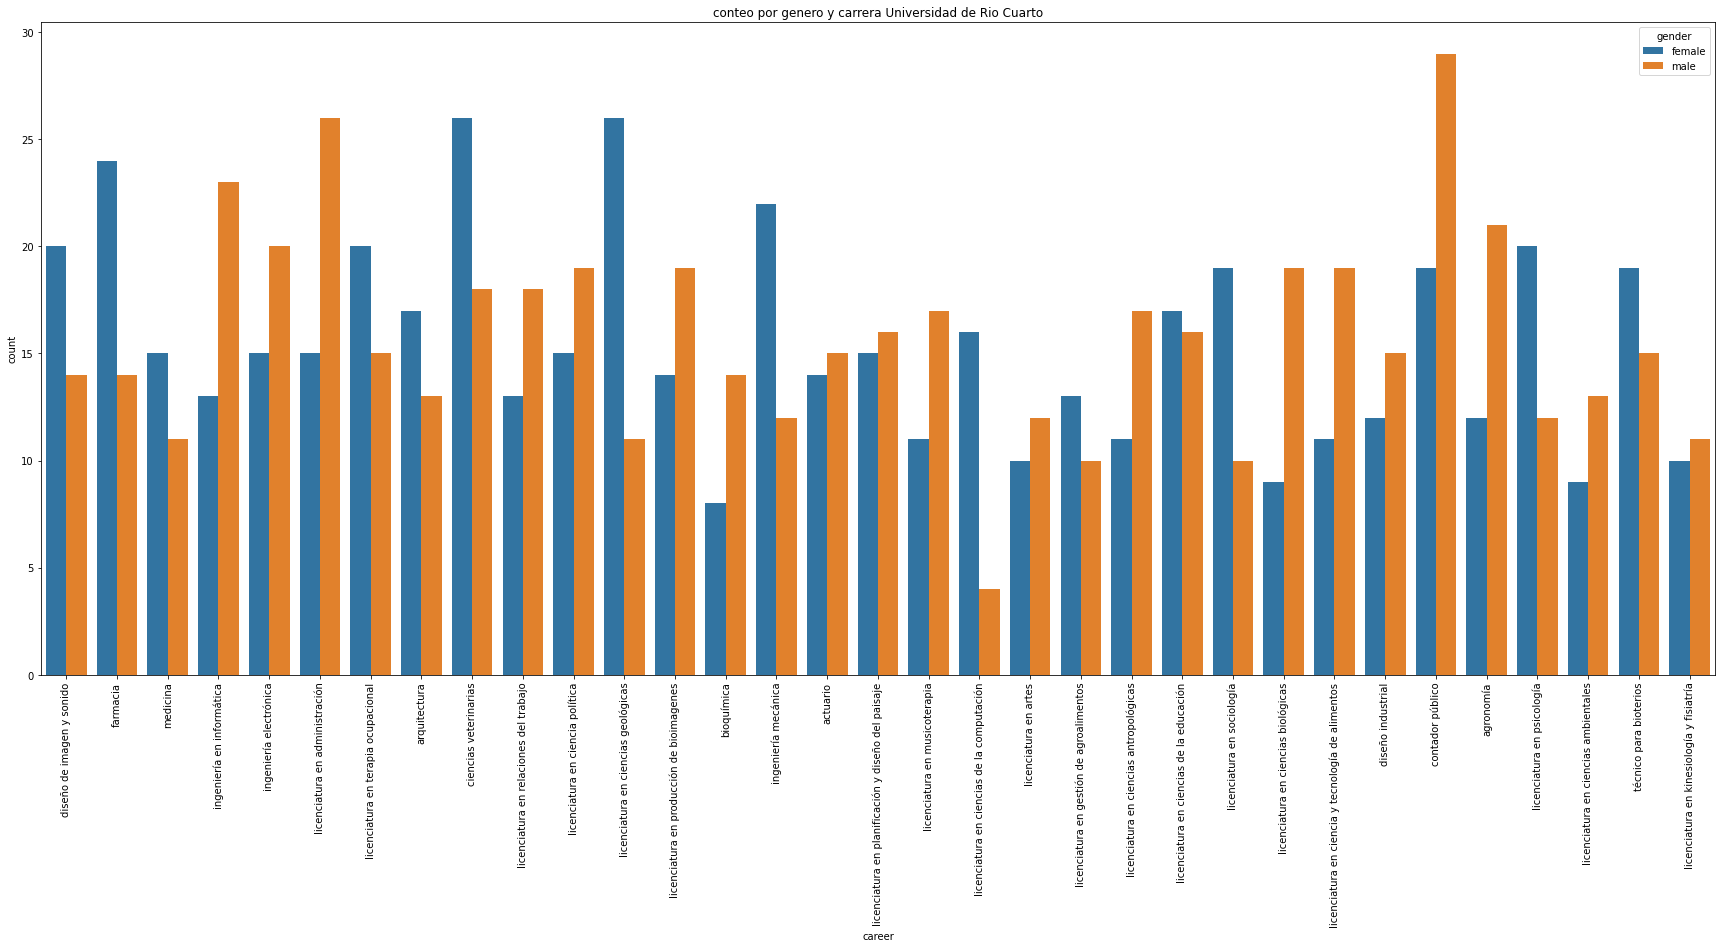

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(30, 12))
plt.title('conteo por genero y carrera Universidad de Rio Cuarto')
sns.countplot(x='career',hue='gender', data=dfr).set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.show()

<AxesSubplot:title={'center':'Rio Cuarto '}, xlabel='carrer_category', ylabel='age'>

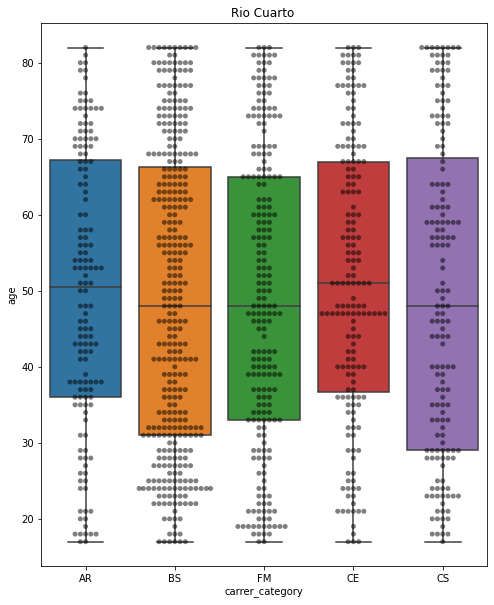

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(8, 10))
plt.title('Rio Cuarto ')
sns.boxplot(x="carrer_category", y="age", data=dfr, ax=ax)
sns.swarmplot(x="carrer_category", y="age", data=dfr, color='black', alpha = 0.5, ax=ax)

#### Universidad Moron
#### En este caso no se observaron diferencias significativas al cruzar la variable edad con genero carrera o región

In [58]:
print(str_aov_kruskal(dfm,'age','carrer_category'))
print(str_aov_kruskal(dfm,'age','gender'))
print(str_aov_kruskal(dfm,'age','career'))
print(str_aov_kruskal(dfm,'age','region'))
print(str_aov_kruskal(dfm,'age','province'))

homocedasticidad
                  Source  ddof1         H     p-unc
Kruskal  carrer_category      4  1.574691  0.813334
homocedasticidad
         Source  ddof1         H    p-unc
Kruskal  gender      1  1.282577  0.25742
homocedasticidad
         Source  ddof1         H     p-unc
Kruskal  career     32  24.81161  0.813586
homocedasticidad
         Source  ddof1         H    p-unc
Kruskal  region      4  2.956032  0.56521
Cant check normality
homocedasticidad
           Source  ddof1          H     p-unc
Kruskal  province     22  14.443467  0.884996


#### Total Universidades
#### Al igual que la universidad de Rio Cuarto se puede observar diferencias por carrera, aunque desaparece la diferencia por género.

In [59]:
print(str_aov_kruskal(dft,'age','carrer_category'))
print(str_aov_kruskal(dft,'age','gender'))
print(str_aov_kruskal(dft,'age','career'))
print(str_aov_kruskal(dft,'age','region'))
print(str_aov_kruskal(dft,'age','province'))

                  Source  ddof1         H     p-unc
Kruskal  carrer_category      4  1.585926  0.811319
homocedasticidad
         Source  ddof1         H     p-unc
Kruskal  gender      1  1.347138  0.245779
homocedasticidad
         Source  ddof1         H     p-unc
Kruskal  career     32  50.66652  0.019208
homocedasticidad
         Source  ddof1         H     p-unc
Kruskal  region      4  3.606633  0.461851
Cant check normality
homocedasticidad
           Source  ddof1       H    p-unc
Kruskal  province     22  22.005  0.45959


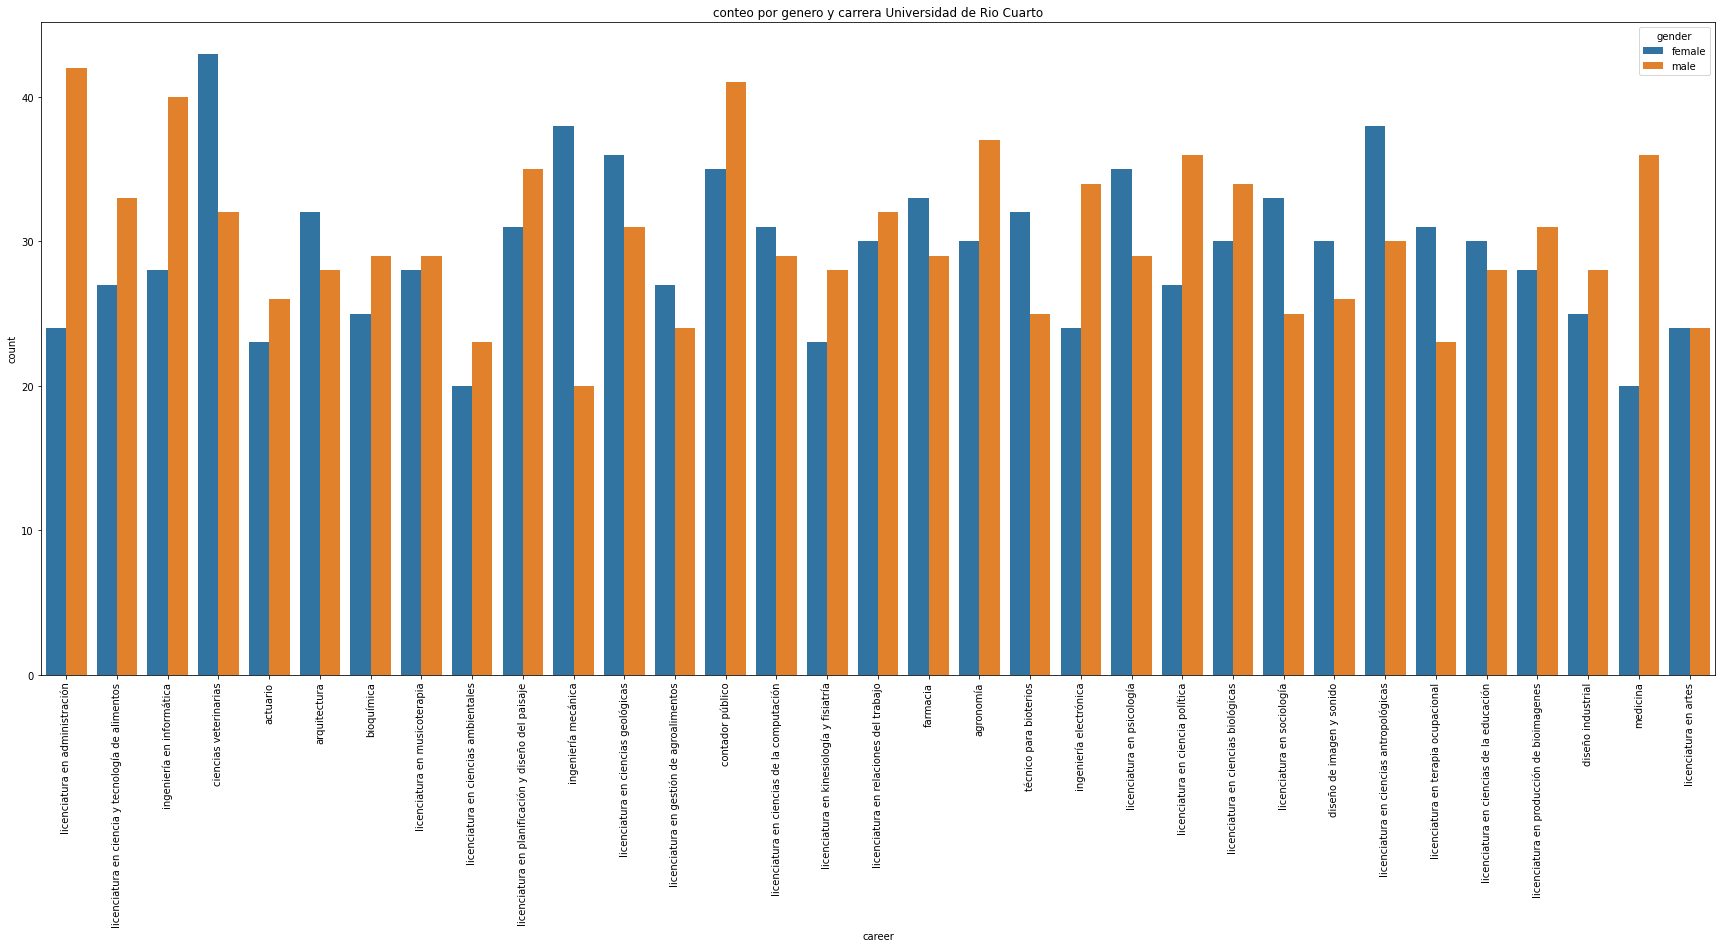

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(30, 12))
plt.title('conteo por genero y carrera Universidad de Rio Cuarto')
sns.countplot(x='career',hue='gender', data=dft).set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.show()

### Comparación y segmentación por universidades


#### edades por genero y universidad

In [61]:
dft['university'].unique()

array(['universidad de morón', 'universidad nacional de río cuarto'],
      dtype=object)

<AxesSubplot:title={'center':'Total universidades'}, xlabel='age', ylabel='university'>

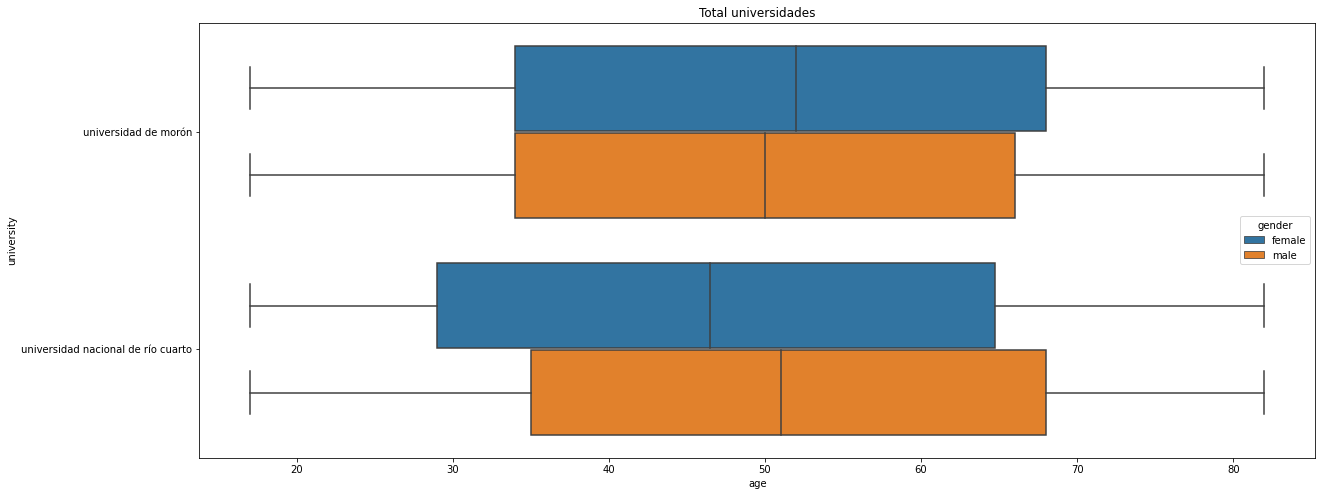

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
plt.title('Total universidades')
sns.boxplot(data=dft, x="age", y="university", hue="gender")

#### edades por region y universidad

<AxesSubplot:title={'center':'Total universidades'}, xlabel='age', ylabel='university'>

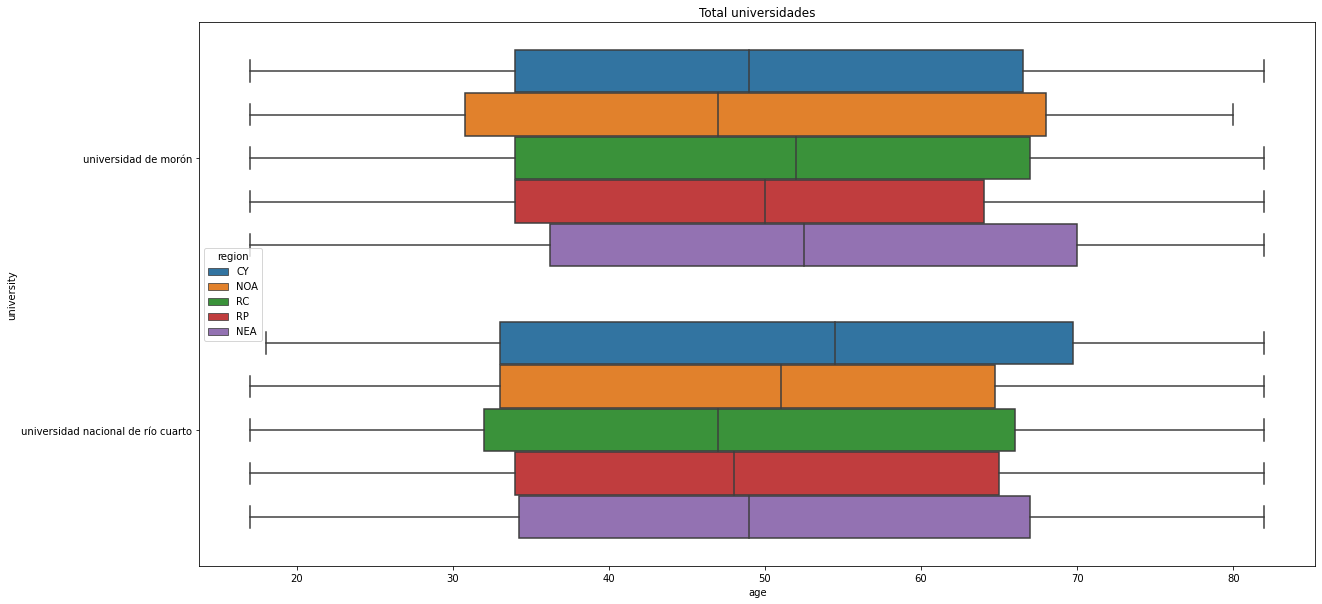

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
plt.title('Total universidades')
sns.boxplot(data=dft, x="age", y="university", hue="region")

#### edad y universidades por categoriia de carreras

<AxesSubplot:title={'center':'Total universidades'}, xlabel='carrer_category', ylabel='age'>

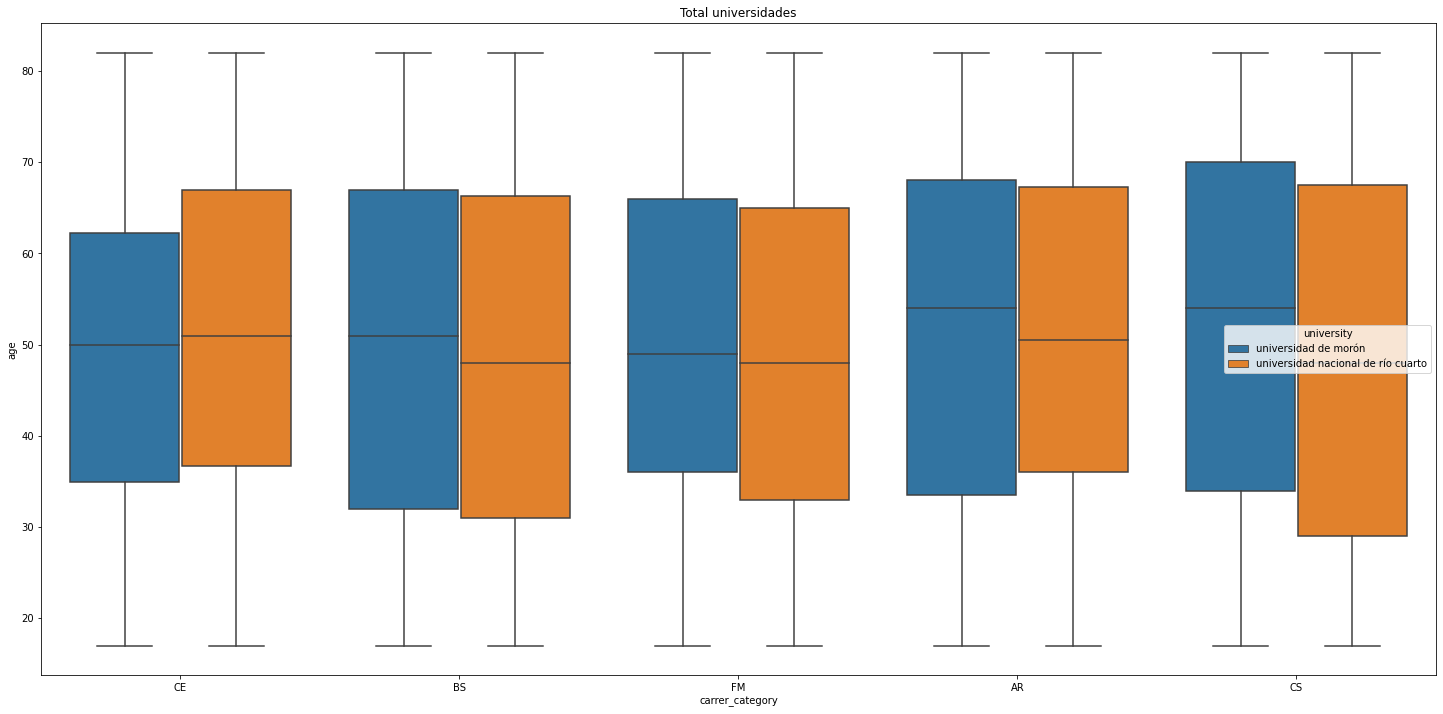

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(25, 12))
plt.title('Total universidades')
sns.boxplot(x="carrer_category", y="age",hue="university", data=dft, ax=ax)

# Conclusión final:



#### Se puede observar una diferencia en la elección de carreras y género, aunque con una significancia poco alta. Para el caso de Rio cuarto esto se manifiesta incluso en edades. Una segmentación mas fuerte puede arrojar resultados de mayor interés como lo muestra el siguiente gráfico:

<AxesSubplot:title={'center':'Total universidades'}, xlabel='carrer_category', ylabel='age'>

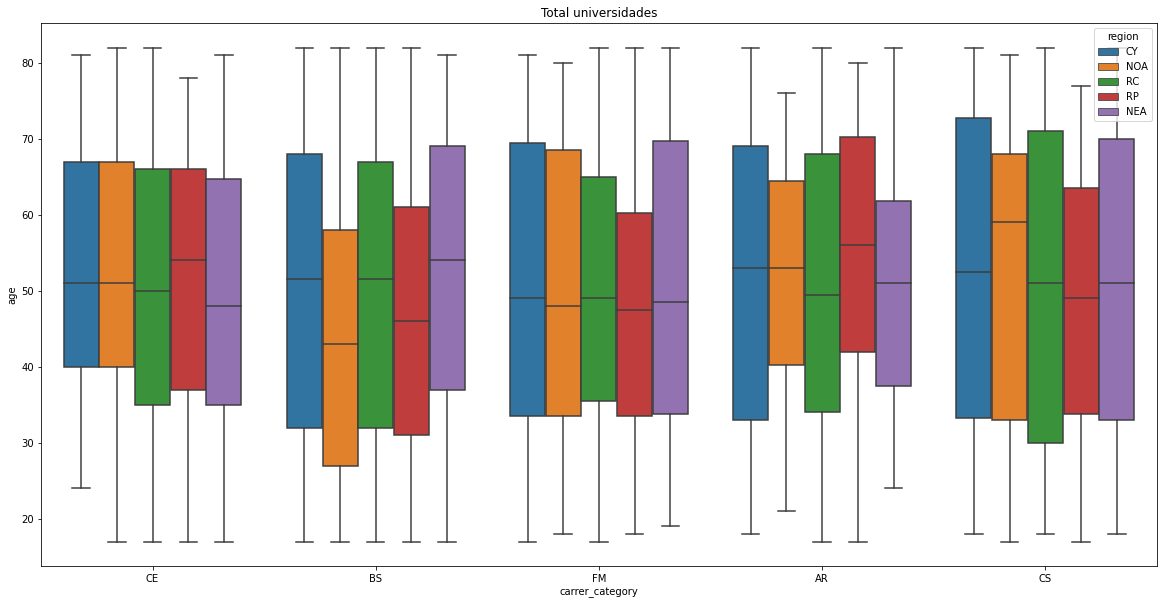

In [65]:

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
plt.title('Total universidades')
sns.boxplot(x="carrer_category", y="age",hue="region", data=dft, ax=ax)


#### La diferencia entre grupos se torna significativa al segmentar la variable edad por área de estudio “físico – matemático” o “ciencias económicas” y luego crear la prueba de hipótesis de diferencia de medias para región de procedencia. En este caso podemos ver que la variabilidad de la edad por región está más presente en (BS) - ciencias de la salud y química, así como en (AR) -carreras relacionadas al Arte.


#### Respecto a las correlaciones y la imposibilidad de crear el estadístico de Pearson se opto por el calculo de la v-Cramer, el cual fue de utilidad para el calculo de un coeficiente que mostrara la relación de dependencia. 
#### Si bien de estos últimos se obtuvo algunos valores razonables, la distribución de los datos parece seguir un rumbo completamente uniforme.


#### Relaciones de genero a 0.5, distribución uniforme en edad (la cual arroja un tercer cuartil octogenario), o incluso una distribución 0.33 0.33 0.33 en los tipos e email (Gmail yahoo Hotmail).
#### Lo cual habla por si solo de la posible procedencia de los datos.


#### Datos de interes

-	Relación de genero 0.5.
-	Dependencia genero – carrera.
-	Rango Inter cuartil de inscriptos entre 35 y 33 años.
-	Diferencia de medias al segmentar por tipo de carrera y comparando. por región (presente en ciencias de la salud y arte).
-	Ausencia de diferencias de edades medias por universidad.
-	diferencias en edades medias por carrera (presente en Rio Cuarto).
-	diferencias de edades por genero (presente en Rio Cuarto).
-	diferencias de edades por carrera en el agregado de las dos Univ.
-	Ausencia de normalidad en la mayoría de las pruebas.
-	Presencia de homocedasticidad en todas las pruebas.
